In [8]:
# Standard library
import re
import sys
import json
import requests
from time        import time, sleep
from pathlib     import Path
from importlib   import reload
from collections import Counter
sys.path.append(str((Path(".").resolve().parent / "src").resolve()))

# Extenal libraries + own
from bs4 import BeautifulSoup, element
import scraper_utils as utils
utils = reload(utils)

# Selenium
import selenium
from   selenium import webdriver
from   selenium.webdriver.common.action_chains import ActionChains
from   selenium.webdriver.common.keys import Keys
from   selenium.webdriver.common.by   import By
from   selenium.webdriver.support.ui  import Select
from   selenium.common.exceptions     import ElementClickInterceptedException

# Navigating the HTML

In [4]:
fruit_url = "https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/fruitandveg-essentials"
resp = requests.get(fruit_url, headers={"content-type":"application/json"})
print(resp.status_code)

200


In [3]:
with open("fruit_essentials.html", "w") as f:
    f.write(resp._content.decode("utf-8"))

200


In [5]:
soup = BeautifulSoup(resp._content.decode("utf-8"), 'html.parser')

In [5]:
with open("fruit_essentials_bs4.html", "w") as f:
    f.write(soup.prettify())
vars(soup.body).keys()

dict_keys(['parser_class', 'name', 'namespace', 'prefix', 'sourceline', 'sourcepos', 'known_xml', 'attrs', 'contents', 'parent', 'previous_element', 'next_element', 'next_sibling', 'previous_sibling', 'hidden', 'can_be_empty_element', 'cdata_list_attributes', 'preserve_whitespace_tags'])

## Getting the `page`

In [99]:
page = utils.fetch_tag(soup.body, "page") # soup.body.contents[1]
page2 = soup.body.div
page3 = soup.find_all(id="page")[0]

In [100]:
hash(page) == hash(page2), hash(page2) == hash(page3)

(True, True)

In [105]:
page2.attrs == {'id':'page'}

True

## Getting the `gridItems`

In [68]:
grid_items_ = page.find_all(attrs={"class":"gridItem"})
len(grid_items_)

60

In [67]:
g = grid_items_[0]
type(g)

bs4.element.Tag

In [22]:
vars(g).keys()

dict_keys(['parser_class', 'name', 'namespace', 'prefix', 'sourceline', 'sourcepos', 'known_xml', 'attrs', 'contents', 'parent', 'previous_element', 'next_element', 'next_sibling', 'previous_sibling', 'hidden', 'can_be_empty_element', 'cdata_list_attributes', 'preserve_whitespace_tags'])

list(enumerate(g.descendants))

In [55]:
g.div.div.div.h3

<h3>
<a href="https://www.sainsburys.co.uk/shop/gb/groceries/product/details/fruitandveg-essentials/sainsburys-loose-fairtrade-bananas">
                                                Sainsbury's Fairtrade Bananas Loose
                                                <img alt="" src="https://assets.sainsburys-groceries.co.uk/gol/1196757/image.jpg"/>
</a>
</h3>

## Item title

In [42]:
list(enumerate(g.div.div.div.h3.descendants))

[(0, '\n'),
 (1,
  <a href="https://www.sainsburys.co.uk/shop/gb/groceries/product/details/fruitandveg-essentials/sainsburys-loose-fairtrade-bananas">
                                                  Sainsbury's Fairtrade Bananas Loose
                                                  <img alt="" src="https://assets.sainsburys-groceries.co.uk/gol/1196757/image.jpg"/>
  </a>),
 (2,
  "\r\n                                                Sainsbury's Fairtrade Bananas Loose\r\n                                                "),
 (3,
  <img alt="" src="https://assets.sainsburys-groceries.co.uk/gol/1196757/image.jpg"/>),
 (4, '\n'),
 (5, '\n')]

In [119]:
[
    (i,item) for i,item in 
    enumerate(grid_items_[5].find_all("h3")[0].descendants)
    if item != "\n"
]

[(1,
  <a href="https://www.sainsburys.co.uk/shop/gb/groceries/product/details/fruitandveg-essentials/sainsburys-red-pepper">
                                                  Sainsbury's Red Pepper
                                                  <img alt="" src="https://assets.sainsburys-groceries.co.uk/gol/1236644/image.jpg"/>
  </a>),
 (2,
  "\r\n                                                Sainsbury's Red Pepper\r\n                                                "),
 (3,
  <img alt="" src="https://assets.sainsburys-groceries.co.uk/gol/1236644/image.jpg"/>)]

In [123]:
"\r\n                                                Sainsbury's Red Pepper\r\n                                                ".strip()

"Sainsbury's Red Pepper"

In [121]:
Counter(
    len(list(g.find_all("h3")[0].descendants))
    for g in grid_items_
)

Counter({6: 60})

## Thumbnail

In [107]:
!wget "https://assets.sainsburys-groceries.co.uk/gol/1196757/image.jpg" -o banana.jpg

In [108]:
req = requests.get("https://assets.sainsburys-groceries.co.uk/gol/1196757/image.jpg")
req.status_code

200

In [110]:
Path("banana.jpg").write_bytes(req.content)

7365

## Prices

In [163]:
## Way too hard-coded

# g.div.div.next_sibling.next_sibling.next_sibling.next_sibling.div.div.div.div
# list(enumerate(g.div.div.next_sibling.next_sibling.next_sibling.next_sibling.div.div.div.div.descendants))

In [126]:
g.find_all(attrs={"class":"pricePerUnit"})[0].string.strip()

'78p'

In [174]:
''.join(g.find_all(attrs={"class":"pricePerUnit"})[0].strings).strip()

'78p'

---

In [66]:
g.find_all(attrs={"class":"pricePerMeasure"})

[<p class="pricePerMeasure">78p<abbr title="per">/</abbr><abbr title="kilogram"><span class="pricePerMeasureMeasure">kg</span></abbr>
 </p>,
 <p class="pricePerMeasure">£16.67<abbr title="per">/</abbr><abbr title="kilogram"><span class="pricePerMeasureMeasure">kg</span></abbr>
 </p>]

In [134]:
list(enumerate(
    g
    .find_all(attrs={"class":"pricePerMeasure"})[0]
    .descendants
))

[(0, '78p'),
 (1, <abbr title="per">/</abbr>),
 (2, '/'),
 (3,
  <abbr title="kilogram"><span class="pricePerMeasureMeasure">kg</span></abbr>),
 (4, <span class="pricePerMeasureMeasure">kg</span>),
 (5, 'kg'),
 (6, '\n')]

In [142]:
tmp = [
    (list((
    g
    .find_all(attrs={"class":"pricePerMeasure"})[0]
    .descendants
    )))
    for g in grid_items_
]

In [144]:
[t for t in tmp if len(t) == 8]

[['£1.00',
  <abbr title="per">/</abbr>,
  '/',
  '100',
  <abbr title="gram"><span class="pricePerMeasureMeasure">g</span></abbr>,
  <span class="pricePerMeasureMeasure">g</span>,
  'g',
  '\n']]

In [164]:
[
    ''.join(
        grid_item
        .find_all(attrs={"class":"pricePerMeasure"})[0].strings
    ).strip()
    for grid_item in grid_items_
][:5]

['78p/kg', '45p/kg', '55p/ea', '65p/kg', '55p/kg']

In [172]:
[
    ''.join(
        grid_item
        .find_all(attrs={"class":"pricePerMeasure"})[0].strings
    ).strip()
    for grid_item in grid_items_
][:5]

['78p/kg', '45p/kg', '55p/ea', '65p/kg', '55p/kg']

In [135]:
list(enumerate(
    g
    .find_all(attrs={"class":"pricePerMeasure"})[0]
    .find_all(attrs={"class":"pricePerMeasureMeasure"})#[0]
))

[(0, <span class="pricePerMeasureMeasure">kg</span>)]

# All together

In [541]:
import sys
import requests
from collections import Counter
from time import time
from pathlib import Path
from importlib import reload

import pandas as pd
from bs4 import BeautifulSoup, element
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt

sys.path.append(str((Path(".").resolve().parent / "src").resolve()))

In [190]:
import scraper_utils as utils
utils = reload(utils)

In [195]:
fruit_url = "https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/fruitandveg-essentials"
t0 = time()
resp = requests.get(fruit_url)#, headers={"content-type":"application/json"})
print(f"Page downloaded in {time() - t0:.6f}s")
soup = BeautifulSoup(resp._content.decode("utf-8"), 'html.parser')

Page downloaded in 0.535065s


In [196]:
items = utils.scrape_items(soup)
len(items)

60

In [197]:
items.head()

,title,thubmnail,price_unit,price_measure
0,Sainsbury's Fairtrade Bananas Loose,,78p,78p/kg
1,Sainsbury's British Carrots Loose,,45p,45p/kg
2,Sainsbury's Whole Cucumber,,55p,55p/ea
3,Sainsbury's Onions Loose,,65p,65p/kg
4,Sainsbury's British Baking Potatoes Loose,,55p,55p/kg


## 120 at once?

In [199]:
fruit_url2 = "https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/CategoryDisplay?langId=44&storeId=10151&catalogId=10241&categoryId=474593&orderBy=TOP_SELLERS%7CSEQUENCING&beginIndex=0&promotionId=&listId=&searchTerm=&hasPreviousOrder=&previousOrderId=&categoryFacetId1=&categoryFacetId2=&ImportedProductsCount=&ImportedStoreName=&ImportedSupermarket=&bundleId=&parent_category_rn=12518&top_category=12518&pageSize=120#langId=44&storeId=10151&catalogId=10241&categoryId=474593&parent_category_rn=12518&top_category=12518&pageSize=120&orderBy=TOP_SELLERS%7CSEQUENCING&searchTerm=&beginIndex=0&facet="
t0 = time()
resp = requests.get(fruit_url2)#, headers={"content-type":"application/json"})
print(f"Page downloaded in {time() - t0:.6f}s")
soup = BeautifulSoup(resp._content.decode("utf-8"), 'html.parser')
items = utils.scrape_items(soup)
items.shape


Page downloaded in 0.983309s


(120, 4)

In [201]:
fruit_url3 = "https://www.sainsburys.co.uk/shop/CategoryDisplay?listId=&catalogId=10241&searchTerm=&beginIndex=120&pageSize=120&orderBy=TOP_SELLERS%7CSEQUENCING&top_category=12518&langId=44&storeId=10151&categoryId=474593&promotionId=&parent_category_rn=12518"
t0 = time()
resp = requests.get(fruit_url3)#, headers={"content-type":"application/json"})
print(f"Page downloaded in {time() - t0:.6f}s")
soup = BeautifulSoup(resp._content.decode("utf-8"), 'html.parser')
items = utils.scrape_items(soup)
items.shape

Page downloaded in 0.549774s


(40, 4)

# Read parquet

In [208]:
import pandas as pd

In [214]:
df_pq = pd.read_parquet("../data/sainsburys-prices.parquet")
df_pq.shape

(320, 6)

In [218]:
df_pq.head()

,title,thubmnail,price_unit,price_measure,scraping_date,category
0,Sainsbury's Fairtrade Bananas Loose,,78p,78p/kg,2022-06-26 02:14:15.508559,fruit-veggies
1,Sainsbury's British Carrots Loose,,45p,45p/kg,2022-06-26 02:14:15.508559,fruit-veggies
2,Sainsbury's Whole Cucumber,,55p,55p/ea,2022-06-26 02:14:15.508559,fruit-veggies
3,Sainsbury's Onions Loose,,65p,65p/kg,2022-06-26 02:14:15.508559,fruit-veggies
4,Sainsbury's British Baking Potatoes Loose,,55p,55p/kg,2022-06-26 02:14:15.508559,fruit-veggies


# Different links?

## Attempt 1: british produce

In [216]:
base_link = "https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/british-produce"
browser_link = "https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/CategoryDisplay?langId=44&storeId=10151&catalogId=10241&categoryId=484866&orderBy=SEQUENCING%7CFAVOURITES_ONLY%7CTOP_SELLERS&beginIndex=0&promotionId=&listId=&searchTerm=&hasPreviousOrder=&previousOrderId=&categoryFacetId1=&categoryFacetId2=&ImportedProductsCount=&ImportedStoreName=&ImportedSupermarket=&bundleId=&parent_category_rn=12518&top_category=12518&pageSize=120#langId=44&storeId=10151&catalogId=10241&categoryId=484866&parent_category_rn=12518&top_category=12518&pageSize=120&orderBy=SEQUENCING%7CFAVOURITES_ONLY%7CTOP_SELLERS&searchTerm=&beginIndex=0&hideFilters=true"
base_hacked_link = base_link + "?langId=44&pageSize=120"


In [220]:
req1 = requests.get(base_link)
req2 = requests.get(browser_link)
req3 = requests.get(base_hacked_link)
# len(req1),len(req2),len(req3)

In [221]:
items1 = utils.scrape_items(BeautifulSoup(req1._content.decode("utf-8"), 'html.parser'))
items2 = utils.scrape_items(BeautifulSoup(req2._content.decode("utf-8"), 'html.parser'))
items3 = utils.scrape_items(BeautifulSoup(req3._content.decode("utf-8"), 'html.parser'))



In [222]:
items1.shape, items2.shape, items3.shape, 

((32, 4), (32, 4), (32, 4))

## Attempt 2: fruit

In [227]:
base_link = "https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/fresh-fruit"
browser_link = "https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/all-fruit#langId=44&storeId=10151&catalogId=10241&categoryId=12545&parent_category_rn=12518&top_category=12518&pageSize=60&orderBy=FAVOURITES_ONLY%7CSEQUENCING%7CTOP_SELLERS&searchTerm=&beginIndex=0&hideFilters=true"
base_hacked_link = base_link + "?langId=44&pageSize=120"


In [228]:
req1 = requests.get(base_link)
req2 = requests.get(browser_link)
req3 = requests.get(base_hacked_link)
# len(req1),len(req2),len(req3)

In [236]:
soup = BeautifulSoup(req1.content.decode(), 'html.parser')


In [250]:
Path("fresh-fruit-home.html").write_text(soup.prettify())

82931

In [ ]:
# list(enumerate(soup.children))

In [229]:
items1 = utils.scrape_items(BeautifulSoup(req1._content.decode("utf-8"), 'html.parser'))
items2 = utils.scrape_items(BeautifulSoup(req2._content.decode("utf-8"), 'html.parser'))
items3 = utils.scrape_items(BeautifulSoup(req3._content.decode("utf-8"), 'html.parser'))



In [230]:
items1.shape, items2.shape, items3.shape, 

((0, 0), (60, 4), (0, 0))

## Attemp 3: Groceries home

### Layer 0

In [257]:
base_link = "https://www.sainsburys.co.uk/shop/gb/groceries"
req1 = requests.get(base_link)
soup = BeautifulSoup(req1.content.decode(), 'html.parser')
Path("groceries-home.html").write_text(soup.prettify())

167210

In [258]:
len(list(soup.find_all(attrs = {'class':'megaNavListItem'})))

29

In [263]:
list(enumerate(soup.find_all(attrs = {'class':'megaNavListItem'})))[10:13]

[(10,
  <li class="megaNavListItem" data-itemid="473117" data-overrideurl="true">
  <a class="megaNavLink" data-itemid="473117" href="/shop/gb/groceries/working-to-feed-the-nation-/latest-information--">
  	                	Working to feed the nation
  	                </a>
  </li>),
 (11,
  <li class="megaNavListItem" data-itemid="355372">
  <a class="megaNavLink" data-itemid="355372" href="https://www.sainsburys.co.uk/shop/gb/groceries/new---trending?fromMegaNav=1">
  	                	Seasonal inspiration<span class="megaNavArrowIcon"></span>
  </a>
  </li>),
 (12,
  <li class="megaNavListItem" data-itemid="248078">
  <a class="megaNavLink" data-itemid="248078" href="https://www.sainsburys.co.uk/shop/gb/groceries/summer?fromMegaNav=1">
  	                	Summer<span class="megaNavArrowIcon"></span>
  </a>
  </li>)]

In [292]:
dict(
    (str(i),i) if i%2==0 else (None,None) for i in range(5)
)

{'0': 0, None: None, '2': 2, '4': 4}

In [286]:
mega_nav = list((soup.find_all(attrs = {'class':'megaNavListItem'})))[11]
print(type(mega_nav), "\n")
list(enumerate(mega_nav.descendants))

<class 'bs4.element.Tag'> 



[(0, '\n'),
 (1,
  <a class="megaNavLink" data-itemid="355372" href="https://www.sainsburys.co.uk/shop/gb/groceries/new---trending?fromMegaNav=1">
  	                	Seasonal inspiration<span class="megaNavArrowIcon"></span>
  </a>),
 (2, '\r\n\t                \tSeasonal inspiration'),
 (3, <span class="megaNavArrowIcon"></span>),
 (4, '\n'),
 (5, '\n')]

In [270]:
list(mega_nav.descendants)[1].attrs

{'class': ['megaNavLink'],
 'data-itemid': '355372',
 'href': 'https://www.sainsburys.co.uk/shop/gb/groceries/new---trending?fromMegaNav=1'}

In [301]:
for i,x in enumerate(soup.find_all(attrs = {'class':'megaNavListItem'})):
    stringos = [s.strip() for s in x.strings if s != "\n"]
    print(i, stringos)

0 ['Browse']
1 ['Groceries']
2 ['Favourites']
3 ['Offers']
4 ['Discover']
5 ['Recipes']
6 ['Book Delivery']
7 ['Delivery Pass']
8 ['Back']
9 ['Groceries home']
10 ['Working to feed the nation']
11 ['Seasonal inspiration']
12 ['Summer']
13 ['Dietary & world foods']
14 ['Price Lock']
15 ['Fruit & vegetables']
16 ['Meat & fish']
17 ['Dairy, eggs & chilled']
18 ['Bakery']
19 ['Frozen']
20 ['Food cupboard']
21 ['Drinks']
22 ['Household']
23 ['Beauty & cosmetics']
24 ['Toiletries & health']
25 ['Homeware & outdoor']
26 ['Baby & toddler']
27 ['Pet']
28 ['Features & articles']


In [299]:
list(list(mega_nav.descendants)[1].strings)

['\r\n\t                \tSeasonal inspiration', '\n']

In [278]:
[(type(x),x) for x in mega_nav.children]

[(bs4.element.NavigableString, '\n'),
 (bs4.element.Tag,
  <a class="megaNavLink" data-itemid="355372" href="https://www.sainsburys.co.uk/shop/gb/groceries/new---trending?fromMegaNav=1">
  	                	Seasonal inspiration<span class="megaNavArrowIcon"></span>
  </a>),
 (bs4.element.NavigableString, '\n')]

In [294]:
vars(list(mega_nav.children)[0])

{'parent': <li class="megaNavListItem" data-itemid="355372">
 <a class="megaNavLink" data-itemid="355372" href="https://www.sainsburys.co.uk/shop/gb/groceries/new---trending?fromMegaNav=1">
 	                	Seasonal inspiration<span class="megaNavArrowIcon"></span>
 </a>
 </li>,
 'previous_element': <li class="megaNavListItem" data-itemid="355372">
 <a class="megaNavLink" data-itemid="355372" href="https://www.sainsburys.co.uk/shop/gb/groceries/new---trending?fromMegaNav=1">
 	                	Seasonal inspiration<span class="megaNavArrowIcon"></span>
 </a>
 </li>,
 'next_element': <a class="megaNavLink" data-itemid="355372" href="https://www.sainsburys.co.uk/shop/gb/groceries/new---trending?fromMegaNav=1">
 	                	Seasonal inspiration<span class="megaNavArrowIcon"></span>
 </a>,
 'next_sibling': <a class="megaNavLink" data-itemid="355372" href="https://www.sainsburys.co.uk/shop/gb/groceries/new---trending?fromMegaNav=1">
 	                	Seasonal inspiration<span class=

In [297]:
getattr(list(mega_nav.children)[1], 'attrs', 'skere')#['href']

{'class': ['megaNavLink'],
 'data-itemid': '355372',
 'href': 'https://www.sainsburys.co.uk/shop/gb/groceries/new---trending?fromMegaNav=1'}

In [281]:
vars(list(mega_nav.children)[1])

{'parser_class': bs4.BeautifulSoup,
 'name': 'a',
 'namespace': None,
 'prefix': None,
 'sourceline': 351,
 'sourcepos': 17,
 'known_xml': False,
 'attrs': {'class': ['megaNavLink'],
  'data-itemid': '355372',
  'href': 'https://www.sainsburys.co.uk/shop/gb/groceries/new---trending?fromMegaNav=1'},
 'contents': ['\r\n\t                \tSeasonal inspiration',
  <span class="megaNavArrowIcon"></span>,
  '\n'],
 'parent': <li class="megaNavListItem" data-itemid="355372">
 <a class="megaNavLink" data-itemid="355372" href="https://www.sainsburys.co.uk/shop/gb/groceries/new---trending?fromMegaNav=1">
 	                	Seasonal inspiration<span class="megaNavArrowIcon"></span>
 </a>
 </li>,
 'previous_element': '\n',
 'next_element': '\r\n\t                \tSeasonal inspiration',
 'next_sibling': '\n',
 'previous_sibling': '\n',
 'hidden': False,
 'can_be_empty_element': False,
 'cdata_list_attributes': {'*': ['class', 'accesskey', 'dropzone'],
  'a': ['rel', 'rev'],
  'link': ['rel', 'rev

### Navigating tree - layer 1

In [334]:
import scraper_utils as utils
utils = reload(utils)

In [341]:
from time import sleep

In [578]:
children = utils.navigate_root(utils.sainburys_home)
children

{'Browse': None,
 'Groceries': None,
 'Favourites': 'LogonView?logonCallerId=LogonButton&isDeliveryPoscodeValid=false&fromFooterMyAccountLink=true&storeId=10151&URL=',
 'Offers': 'https://www.sainsburys.co.uk/shop/gb/groceries/great-offers',
 'Discover': 'https://www.sainsburys.co.uk/shop/gb/groceries/discover',
 'Recipes': 'http://recipes.sainsburys.co.uk',
 'Book Delivery': 'https://www.sainsburys.co.uk/shop/PostcodeCheckView?currentPageUrl=http%3A%2F%2Fwww.sainsburys.co.uk%2Fshop%2FTopCategoriesDisplayView%3FcatalogId%3D10241%26storeId%3D10151%26langId%3D44&catalogId=10241&langId=44&storeId=10151',
 'Delivery Pass': '/shop/gb/saver',
 'Back': '#',
 'Groceries home': 'https://www.sainsburys.co.uk/shop/MobileHomeView?storeId=10151&langId=44',
 'Working to feed the nation': '/shop/gb/groceries/working-to-feed-the-nation-/latest-information--',
 'Seasonal inspiration': 'https://www.sainsburys.co.uk/shop/gb/groceries/new---trending?fromMegaNav=1',
 'Summer': 'https://www.sainsburys.co.uk

In [345]:
children_pages = {}
for title,link in children.items():
    sleep(1)
    if link is None:
        continue
    if not link.startswith('https://www.sainsburys.co.uk/'):
        continue
    children_pages[title] = requests.get(link)

In [347]:
children_soups = {
    t:BeautifulSoup(resp.content.decode(), 'html.parser')
    for t,resp in children_pages.items()
}

In [350]:
fruit = children_soups['Fruit & vegetables']
Path('lvl1-fruit.html').write_text(fruit.prettify())

119415

In [385]:
tmp = fruit.find_all(attrs = {'id':"breadcrumbNav"})
fruit_breadcrumb = list(tmp)[0]
list(enumerate(
    list(
        list(
            list(fruit_breadcrumb.children)[3]
            .children
        )[1]
    )#[5]#.children
))

[(0, <span class="corner"></span>),
 (1,
  <a href="https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg"><span>Fruit &amp; vegetables</span></a>),
 (2, '\n'),
 (3, <span class="arrow last"></span>),
 (4, '\n'),
 (5,
  <div>
  <p>Select an option:</p>
  <ul>
  <li><a href="https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/british-produce">British produce</a></li>
  <li><a href="https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/fruitandveg-essentials">Fruit &amp; veg essentials</a></li>
  <li><a href="https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/fresh-fruit">Fresh fruit</a></li>
  <li><a href="https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/fresh-vegetables">Fresh vegetables</a></li>
  <li><a href="https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/fresh-salad">Fresh salad</a></li>
  <li><a href="https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/prepared-ready-to-eat">Prepared fruit, veg &amp; salad</a></li>
  <li><a href="https://www.

In [413]:
i = 4
list(enumerate(fruit_breadcrumb.descendants))[(i*5):((i+1)*5)]
x = list(fruit_breadcrumb.descendants)[21]
x

<li><a href="https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/british-produce">British produce</a></li>

In [411]:
x.contents[0].attrs

{'href': 'https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/british-produce'}

In [414]:
x.name

'li'

In [429]:
([
    item for item in
    fruit_breadcrumb.descendants
    if getattr(item, 'name', '') == 'li'
    and hasattr(getattr(item, 'contents', '')[0], 'attrs')
    and getattr(item, 'contents')[0].attrs.get('href', '')
])

[<li><a href="https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/british-produce">British produce</a></li>,
 <li><a href="https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/fruitandveg-essentials">Fruit &amp; veg essentials</a></li>,
 <li><a href="https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/fresh-fruit">Fresh fruit</a></li>,
 <li><a href="https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/fresh-vegetables">Fresh vegetables</a></li>,
 <li><a href="https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/fresh-salad">Fresh salad</a></li>,
 <li><a href="https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/prepared-ready-to-eat">Prepared fruit, veg &amp; salad</a></li>,
 <li><a href="https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/fresh-herbs-ingredients">Fresh herbs &amp; ingredients</a></li>,
 <li><a href="https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/flowers---seeds">Flowers &amp; plants</a></li>,
 <li><a href="https://www.sainsbury

### Layer 2

In [433]:
layer2 = "https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/fruitandveg-essentials"
layer2_req = requests.get(layer2)
fruit_ess = BeautifulSoup(layer2_req.content.decode(), 'html.parser')

In [431]:
Path('lvl2-fruit-essentials.html').write_text(fruit_ess.prettify())

736875

In [432]:
grid_items = list(fruit_ess.find_all(attrs={"class":"gridItem"}))
len(grid_items)

60

#### Can we hack the page size?

In [437]:
layer2_req_vars = vars(layer2_req)
list(layer2_req_vars.keys())

['_content',
 '_content_consumed',
 '_next',
 'status_code',
 'headers',
 'raw',
 'url',
 'encoding',
 'history',
 'reason',
 'cookies',
 'elapsed',
 'request',
 'connection']

In [ ]:
redir = vars(layer2_req_vars['history'][0])['headers']['Location']

In [568]:
redir_mod_1 = re.sub(r'(storeId=\d{1,7}&)',r'\1beginIndex=0&pageSize=120&',redir)
redir_mod_2 = re.sub(r'(storeId=\d{1,7}&)',r'\1beginIndex=60&pageSize=120&',redir)
redir_mod_3 = re.sub(r'(storeId=\d{1,7}&)',r'\1beginIndex=120&pageSize=120&',redir)
redir_mod_4 = re.sub(r'(storeId=\d{1,7}&)',r'\1beginIndex=180&pageSize=120&',redir)

In [569]:
fruit_ess_2_req_1 = requests.get(redir_mod_1)
fruit_ess_2_req_2 = requests.get(redir_mod_2)
fruit_ess_2_req_3 = requests.get(redir_mod_3)
fruit_ess_2_req_4 = requests.get(redir_mod_4)

In [570]:
lines_1 = set(fruit_ess_2_req_1.content.decode().split("\n"))
lines_2 = set(fruit_ess_2_req_2.content.decode().split("\n"))
len(lines_1), len(lines_2), len(lines_1&lines_2), len(lines_1|lines_2)

(4819, 4819, 4809, 4829)

In [571]:
fruit_ess_2_bs_1 = BeautifulSoup(fruit_ess_2_req_1.content.decode(), 'html.parser')
fruit_ess_2_bs_2 = BeautifulSoup(fruit_ess_2_req_2.content.decode(), 'html.parser')
fruit_ess_2_bs_3 = BeautifulSoup(fruit_ess_2_req_3.content.decode(), 'html.parser')
fruit_ess_2_bs_4 = BeautifulSoup(fruit_ess_2_req_4.content.decode(), 'html.parser')

In [572]:
print(
    len(list(fruit_ess_2_bs_1.find_all(attrs={"class":"gridItem"}))),
    len(list(fruit_ess_2_bs_2.find_all(attrs={"class":"gridItem"}))),
    len(list(fruit_ess_2_bs_3.find_all(attrs={"class":"gridItem"}))),
    len(list(fruit_ess_2_bs_4.find_all(attrs={"class":"gridItem"})))
)

120 120 120 120


In [573]:
def scrape_item_list(grid_items):
    items = []
    for i,g in enumerate(grid_items):
        title, thubmnail = utils.scape_item_thumbnail(g)
        price_unit       = utils.scrape_price_per_unit(g)
        price_measure    = utils.scrape_price_per_measure(g)
        items.append({
            'title'         : title,
            'thubmnail'     : thubmnail,
            'price_unit'    : price_unit,
            'price_measure' : price_measure
        })
    items_df = (
        pd.DataFrame.from_dict(items)
        .assign(scraping_date = str(datetime.now()))
    )
    return items_df

In [574]:
fruit_ess_2_bs_1_df = scrape_item_list(fruit_ess_2_bs_1.find_all(attrs={"class":"gridItem"}))
fruit_ess_2_bs_2_df = scrape_item_list(fruit_ess_2_bs_2.find_all(attrs={"class":"gridItem"}))
fruit_ess_2_bs_3_df = scrape_item_list(fruit_ess_2_bs_3.find_all(attrs={"class":"gridItem"}))
fruit_ess_2_bs_4_df = scrape_item_list(fruit_ess_2_bs_4.find_all(attrs={"class":"gridItem"}))

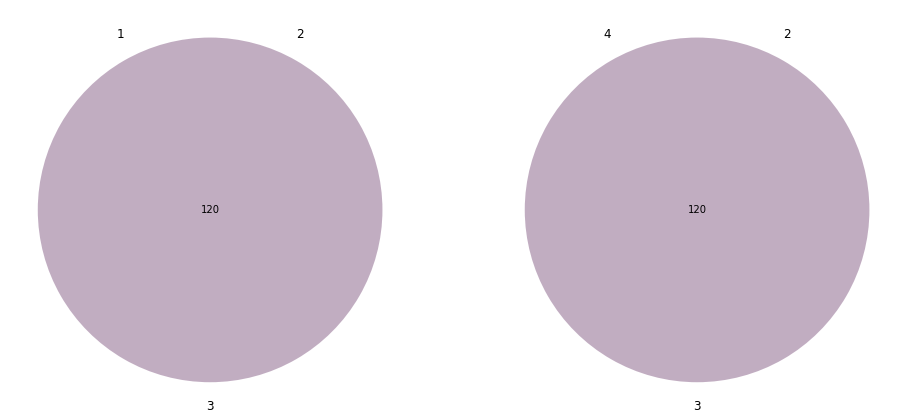

In [575]:
plt.figure(figsize = (16,8), facecolor="white")
plt.subplot(121)
venn3([
    set(fruit_ess_2_bs_1_df['title']),
    set(fruit_ess_2_bs_2_df['title']),
    set(fruit_ess_2_bs_3_df['title'])
], (1,2,3))
plt.subplot(122)
venn3([
    set(fruit_ess_2_bs_4_df['title']),
    set(fruit_ess_2_bs_2_df['title']),
    set(fruit_ess_2_bs_3_df['title'])
], (4,2,3))

In [565]:
fruit_ess_2_bs_1.find_all(attrs = {'id':"resultsHeading"})

[<h1 class="resultsHeading" id="resultsHeading">
 	        Fruit &amp; veg essentials (161 products available)
 	    </h1>]

> Not in this way

# Selenium

In [3]:
# layer2 = "https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/fruitandveg-essentials"
layer0 = "https://www.sainsburys.co.uk/shop/gb/groceries"
driver = webdriver.Firefox()
# driver.get(layer0)

In [9]:
a = ActionChains(driver)
driver.get(layer0)
driver.title
sleep(5)
# Turn into Explicit Wait
try:
    cookies_button_xpath = """//*[@id="onetrust-accept-btn-handler"]"""
    accept_cookies_button = driver.find_element(By.XPATH, cookies_button_xpath)
    accept_cookies_button.click()
except:
    pass

## to hack page size

In [11]:
elem = driver.find_element(By.ID, "pageSize")
elem

<selenium.webdriver.remote.webelement.WebElement (session="1389d10b-f131-4f25-9e95-7961cd781686", element="efbd6f8a-e1bc-4a6b-842a-5f4af595928c")>

In [12]:
xpath = '//*[@id="pageSize"]'
elem = driver.find_element(By.XPATH, xpath)
elem

<selenium.webdriver.remote.webelement.WebElement (session="1389d10b-f131-4f25-9e95-7961cd781686", element="efbd6f8a-e1bc-4a6b-842a-5f4af595928c")>

In [13]:
[
    e.get_attribute('value') for e in
    elem.find_elements(By.TAG_NAME, 'option')
]

['48', '60', '72', '90', '120']

In [14]:
select = Select(elem)
try:
    select.select_by_value('120')
except ElementClickInterceptedException as e:
    cookies_button_xpath = """//*[@id="onetrust-accept-btn-handler"]"""
    accept_cookies_button = driver.find_element(By.XPATH, cookies_button_xpath)
    accept_cookies_button.click()
finally:
    select.select_by_value('120')


StaleElementReferenceException: Message: The element reference of <select id="pageSize" name="pageSize"> is stale; either the element is no longer attached to the DOM, it is not in the current frame context, or the document has been refreshed
Stacktrace:
WebDriverError@chrome://remote/content/shared/webdriver/Errors.jsm:186:5
StaleElementReferenceError@chrome://remote/content/shared/webdriver/Errors.jsm:467:5
element.resolveElement@chrome://remote/content/marionette/element.js:681:11
evaluate.fromJSON@chrome://remote/content/marionette/evaluate.js:254:26
evaluate.fromJSON@chrome://remote/content/marionette/evaluate.js:262:29
evaluate.fromJSON@chrome://remote/content/marionette/evaluate.js:262:29
receiveMessage@chrome://remote/content/marionette/actors/MarionetteCommandsChild.jsm:79:29


## N of items in page

In [ ]:
elem = driver.find_element(By.ID, "pageSize")

## Next page

In [669]:
next_page_xpath = """/html/body/div[8]/div[2]/div[1]/div[4]/div[2]/div[1]/ul[2]/li[3]/a"""
next_page = driver.find_element(By.XPATH, next_page_xpath)
next_page

<selenium.webdriver.remote.webelement.WebElement (session="e3571dd2-ec3b-46c3-992b-9b3317340127", element="a04fc1d8-e876-490b-a417-0bba3800b952")>

In [669]:
next_page_xpath = """/html/body/div[8]/div[2]/div[1]/div[4]/div[2]/div[1]/ul[2]/li[3]/a"""
next_page = driver.find_element(By.XPATH, next_page_xpath)
next_page

<selenium.webdriver.remote.webelement.WebElement (session="e3571dd2-ec3b-46c3-992b-9b3317340127", element="a04fc1d8-e876-490b-a417-0bba3800b952")>

In [670]:
next_page.click()

In [ ]:
# elem.clear()
# elem.send_keys("pycon")
# elem.send_keys(Keys.RETURN)
# assert "No results found." not in driver.page_source
# driver.close()

In [642]:
driver.close()

## Use `Groceries` to navigate categories

In [784]:
main_arrow_x = """//*[@id="mainNavArrow"]"""
arrow = driver.find_element(By.XPATH, main_arrow_x)
arrow

<selenium.webdriver.remote.webelement.WebElement (session="f13ac1a5-da5a-436e-8687-dc678b3dd473", element="de78bb3f-9080-4177-8538-01148200bfd1")>

In [785]:
# main_arrow_x = """//*[@id="mainNavArrow"]"""
arrow = driver.find_element(By.LINK_TEXT, "Groceries")
arrow

<selenium.webdriver.remote.webelement.WebElement (session="f13ac1a5-da5a-436e-8687-dc678b3dd473", element="4f17f503-2140-43e6-a729-9245dee1c086")>

In [786]:
a = ActionChains(driver)
#hover over element
a.move_to_element(arrow).perform()

In [691]:
fruit_in_menu = driver.find_element(By.LINK_TEXT, "Fruit & vegetables")
fruit_in_menu

<selenium.webdriver.remote.webelement.WebElement (session="e3571dd2-ec3b-46c3-992b-9b3317340127", element="0591865d-d107-4ab5-a62c-e3c0025bf35e")>

In [694]:
fruit_in_menu_xpath = """/html/body/div[8]/div[1]/div/div[3]/div[2]/div/div[2]/ul[2]/li[8]/a"""
fruit_in_menu = driver.find_element(By.XPATH, fruit_in_menu_xpath)
fruit_in_menu

<selenium.webdriver.remote.webelement.WebElement (session="e3571dd2-ec3b-46c3-992b-9b3317340127", element="0591865d-d107-4ab5-a62c-e3c0025bf35e")>

In [734]:
a.move_to_element(fruit_in_menu).perform()

StaleElementReferenceException: Message: The element reference of [object String] "{\"element-6066-11e4-a52e-4f735466cecf\":\"0591865d-d107-4ab5-a62c-e3c0025bf35e\"}" is stale; either the element is no longer attached to the DOM, it is not in the current frame context, or the document has been refreshed
Stacktrace:
WebDriverError@chrome://remote/content/shared/webdriver/Errors.jsm:183:5
StaleElementReferenceError@chrome://remote/content/shared/webdriver/Errors.jsm:464:5
element.resolveElement@chrome://remote/content/marionette/element.js:681:11
evaluate.fromJSON@chrome://remote/content/marionette/evaluate.js:254:26
evaluate.fromJSON@chrome://remote/content/marionette/evaluate.js:262:29
evaluate.fromJSON/<@chrome://remote/content/marionette/evaluate.js:245:38
evaluate.fromJSON@chrome://remote/content/marionette/evaluate.js:245:20
evaluate.fromJSON@chrome://remote/content/marionette/evaluate.js:262:29
evaluate.fromJSON/<@chrome://remote/content/marionette/evaluate.js:245:38
evaluate.fromJSON@chrome://remote/content/marionette/evaluate.js:245:20
evaluate.fromJSON@chrome://remote/content/marionette/evaluate.js:262:29
receiveMessage@chrome://remote/content/marionette/actors/MarionetteCommandsChild.jsm:79:29


## Navigate Groceries List

In [946]:
arrow = driver.find_element(By.LINK_TEXT, "Groceries")
a.move_to_element(arrow).perform()

In [941]:
# groceries_list = driver.find_elements(By.CLASS_NAME, "megaNavLink.megaNavActiveLink")
groceries_list = [
    item for item in
    driver.find_elements(By.CLASS_NAME, "megaNavListItem")
    if item.rect['x'] != 0 and item.rect['x'] != 0
]
# groceries_list[0].click()
# groceries_list.is_displayed()
len(groceries_list)

19

### Exploratory

In [942]:
[(i, item.text, item.rect) for i,item in enumerate(groceries_list)]

[(0,
  'Working to feed the nation',
  {'x': 54.0, 'y': 195.0, 'width': 223.0, 'height': 34.0}),
 (1,
  'Seasonal inspiration',
  {'x': 54.0, 'y': 229.0, 'width': 223.0, 'height': 34.0}),
 (2, 'Summer', {'x': 54.0, 'y': 263.0, 'width': 223.0, 'height': 34.0}),
 (3,
  'Dietary & world foods',
  {'x': 54.0, 'y': 297.0, 'width': 223.0, 'height': 34.0}),
 (4, 'Price Lock', {'x': 54.0, 'y': 331.0, 'width': 223.0, 'height': 34.0}),
 (5,
  'Fruit & vegetables',
  {'x': 54.0, 'y': 365.0, 'width': 223.0, 'height': 34.0}),
 (6, 'Meat & fish', {'x': 54.0, 'y': 399.0, 'width': 223.0, 'height': 34.0}),
 (7,
  'Dairy, eggs & chilled',
  {'x': 54.0, 'y': 433.0, 'width': 223.0, 'height': 34.0}),
 (8, 'Bakery', {'x': 54.0, 'y': 467.0, 'width': 223.0, 'height': 34.0}),
 (9, 'Frozen', {'x': 54.0, 'y': 501.0, 'width': 223.0, 'height': 34.0}),
 (10,
  'Food cupboard',
  {'x': 54.0, 'y': 535.0, 'width': 223.0, 'height': 34.0}),
 (11, 'Drinks', {'x': 54.0, 'y': 569.0, 'width': 223.0, 'height': 34.0}),
 (12, 

In [930]:
a.move_to_element(groceries_list[1]).perform()

In [953]:
a.move_to_element(groceries_list[5]).perform()

> Moving directly sometimes does not work. Make sure to move item by item

In [908]:
a.move_to_element(groceries_list[5]).click().perform()

In [954]:
groceries_list_lvl1 = [
            item for item in
            driver.find_elements(By.CLASS_NAME, "megaNavListItem")
            if item.rect['x'] != 0 and item.rect['x'] != 0
        ]

In [955]:
[f"{item.text:>30}|{item.rect})" for item in groceries_list_lvl1]

["    Working to feed the nation|{'x': 54.0, 'y': 195.0, 'width': 223.0, 'height': 34.0})",
 "          Seasonal inspiration|{'x': 54.0, 'y': 229.0, 'width': 223.0, 'height': 34.0})",
 "                        Summer|{'x': 54.0, 'y': 263.0, 'width': 223.0, 'height': 34.0})",
 "         Dietary & world foods|{'x': 54.0, 'y': 297.0, 'width': 223.0, 'height': 34.0})",
 "                    Price Lock|{'x': 54.0, 'y': 331.0, 'width': 223.0, 'height': 34.0})",
 "            Fruit & vegetables|{'x': 54.0, 'y': 365.0, 'width': 223.0, 'height': 34.0})",
 "                   Meat & fish|{'x': 54.0, 'y': 399.0, 'width': 223.0, 'height': 34.0})",
 "         Dairy, eggs & chilled|{'x': 54.0, 'y': 433.0, 'width': 223.0, 'height': 34.0})",
 "                        Bakery|{'x': 54.0, 'y': 467.0, 'width': 223.0, 'height': 34.0})",
 "                        Frozen|{'x': 54.0, 'y': 501.0, 'width': 223.0, 'height': 34.0})",
 "                 Food cupboard|{'x': 54.0, 'y': 535.0, 'width': 223.0, 'height

In [956]:
gro_dict = {item.text:item for item in 
            driver.find_elements(By.CLASS_NAME, "megaNavListItem")
            if item.rect['x'] != 0 and item.rect['x'] != 0}

In [962]:
# key = "Fresh salad"
key = "Fruit & veg essentials"

In [963]:
gro_dict[key].text

'Fruit & veg essentials'

In [964]:
gro_dict[key].get_attribute('href')

In [965]:
gro_dict[key].get_attribute('value')

'0'

In [966]:
groceries_list_lvl1[20].text

'British produce'

In [967]:
a.move_to_element(groceries_list_lvl1[20]).perform()
groceries_list_lvl1[20].click()

for at in dir(groceries_list_lvl1[20]):
    if not at.startswith('__'):
        try:
            print((at, getattr(groceries_list_lvl1[20], at)))
        except:
            print(at, 'failed')

In [853]:
for item in groceries_list_lvl1:
    if item.text == "Fresh fruit":
        a.move_to_element(item).perform()

StaleElementReferenceException: Message: The element reference of <li class="megaNavListItem"> is stale; either the element is no longer attached to the DOM, it is not in the current frame context, or the document has been refreshed
Stacktrace:
WebDriverError@chrome://remote/content/shared/webdriver/Errors.jsm:183:5
StaleElementReferenceError@chrome://remote/content/shared/webdriver/Errors.jsm:464:5
element.resolveElement@chrome://remote/content/marionette/element.js:681:11
evaluate.fromJSON@chrome://remote/content/marionette/evaluate.js:254:26
evaluate.fromJSON@chrome://remote/content/marionette/evaluate.js:262:29
receiveMessage@chrome://remote/content/marionette/actors/MarionetteCommandsChild.jsm:79:29


In [854]:
groceries_list_lvl2 = [
        item for item in
        driver.find_elements(By.CLASS_NAME, "megaNavListItem")
        if item.rect['x'] != 0 and item.rect['x'] != 0
    ]
[f"{item.text:>30}|{item.rect})" for item in groceries_list_lvl2]

["    Working to feed the nation|{'x': 54.0, 'y': 195.0, 'width': 223.0, 'height': 34.0})",
 "          Seasonal inspiration|{'x': 54.0, 'y': 229.0, 'width': 223.0, 'height': 34.0})",
 "                        Summer|{'x': 54.0, 'y': 263.0, 'width': 223.0, 'height': 34.0})",
 "         Dietary & world foods|{'x': 54.0, 'y': 297.0, 'width': 223.0, 'height': 34.0})",
 "                    Price Lock|{'x': 54.0, 'y': 331.0, 'width': 223.0, 'height': 34.0})",
 "            Fruit & vegetables|{'x': 54.0, 'y': 365.0, 'width': 223.0, 'height': 34.0})",
 "                   Meat & fish|{'x': 54.0, 'y': 399.0, 'width': 223.0, 'height': 34.0})",
 "         Dairy, eggs & chilled|{'x': 54.0, 'y': 433.0, 'width': 223.0, 'height': 34.0})",
 "                        Bakery|{'x': 54.0, 'y': 467.0, 'width': 223.0, 'height': 34.0})",
 "                        Frozen|{'x': 54.0, 'y': 501.0, 'width': 223.0, 'height': 34.0})",
 "                 Food cupboard|{'x': 54.0, 'y': 535.0, 'width': 223.0, 'height

In [1009]:
driver.execute_script("window.scrollTo(0,0)")
arrow = driver.find_element(By.LINK_TEXT, "Groceries")
a.move_to_element(arrow).perform()
sleep(0.25)
print("number of megaNavListItem:", len(megaNavListItem))

groceries_list = [
    item for item in
    driver.find_elements(By.CLASS_NAME, "megaNavListItem")
    if item.rect['x'] != 0 and item.rect['y'] != 0
]
print("number of valid items:", len(groceries_list))

height_offset = 50
for i,gro_item in enumerate(groceries_list):
    sleep(0.75)
    try:
        a.move_to_element(gro_item).perform()
        groceries_list_lvl1 = [
            item for item in
            driver.find_elements(By.CLASS_NAME, "megaNavListItem")
            if item.rect['x'] != 0 and item.rect['y'] != 0
        ]
        print(f"[{i:2}]{gro_item.text:>25} | {len(groceries_list_lvl1)} categories visible")
    except:
        sleep(0.5)
        # driver.execute_script("arguments[0].scrollIntoView(true);", gro_item)
        driver.execute_script(f"window.scrollTo(0,{height_offset})")
        height_offset += 50
        sleep(0.5)
        groceries_list_lvl1 = [
            item for item in
            driver.find_elements(By.CLASS_NAME, "megaNavListItem")
            if item.rect['x'] != 0 and item.rect['y'] != 0
        ]
        
        try:
            cat_name = gro_item.text
        except:
            cat_name = 'error'
        print(f"[{i:2}]{cat_name:>25} | {len(groceries_list_lvl1)} categories visible")
    

number of megaNavListItem: 29
number of valid items: 32
[ 0]Working to feed the nation | 32 categories visible
[ 1]     Seasonal inspiration | 37 categories visible
[ 2]                   Summer | 33 categories visible
[ 3]    Dietary & world foods | 40 categories visible
[ 4]               Price Lock | 32 categories visible
[ 5]       Fruit & vegetables | 39 categories visible
[ 6]              Meat & fish | 40 categories visible
[ 7]    Dairy, eggs & chilled | 39 categories visible
[ 8]                   Bakery | 39 categories visible
[ 9]                   Frozen | 41 categories visible
[10]            Food cupboard | 42 categories visible
[11]                   Drinks | 40 categories visible
[12]                Household | 40 categories visible
[13]       Beauty & cosmetics | 38 categories visible
[14]      Toiletries & health | 41 categories visible
[15]       Homeware & outdoor | 35 categories visible
[16]           Baby & toddler | 38 categories visible
[17]                     

In [1026]:
driver.execute_script("window.scrollTo(0,0)")
arrow = driver.find_element(By.LINK_TEXT, "Groceries")
a.move_to_element(arrow).perform()
sleep(0.25)

groceries_list = [
    item for item in
    driver.find_elements(By.CLASS_NAME, "megaNavListItem")
    if item.rect['x'] != 0 and item.rect['y'] != 0
]
print("number of megaNavListItem found:", len(groceries_list))

groceries_list_valid = []
category_names = []
for gro_item in groceries_list:
    try:
        category_names.append(gro_item.text)
        groceries_list_valid.append(gro_item)
    except:
        pass
print("number of valid megaNavListItem:", len(groceries_list_valid))

current_categories = len(groceries_list_valid)
height_offset = 50
for i,gro_item in enumerate(groceries_list_valid):
    sleep(0.75)
    try:
        a.move_to_element(gro_item).perform()
        groceries_list_sub = [
            item for item in
            driver.find_elements(By.CLASS_NAME, "megaNavListItem")
            if item.rect['x'] != 0 and item.rect['y'] != 0
        ]
    except:
        sleep(0.5)
        # driver.execute_script("arguments[0].scrollIntoView(true);", gro_item)
        driver.execute_script(f"window.scrollTo(0,{height_offset})")
        try:
            a.move_to_element(gro_item).perform()
        except:
            pass
        height_offset += 50
        sleep(0.5)
        groceries_list_sub = [
            item for item in
            driver.find_elements(By.CLASS_NAME, "megaNavListItem")
            if item.rect['x'] != 0 and item.rect['y'] != 0
        ]
    try:
        cat_name = gro_item.text
    except:
        continue
    sub_categories_names = []
    for gro_sub_item in groceries_list_sub:
        try:
            sub_categories_names.append(gro_sub_item.text)
        except:
            pass
    new_categories = set(sub_categories_names) - set(category_names)
    print(f"{i:-^80}")
    print(f"{f'New categories for {cat_name}':^80}")
    print(new_categories)
    # print(f"[{i:2}]{cat_name:>25} | {len(groceries_list_sub)} categories visible")
    

number of megaNavListItem found: 24
number of valid megaNavListItem: 24
---------------------------------------0----------------------------------------
                 New categories for Working to feed the nation                  
set()
---------------------------------------1----------------------------------------
                    New categories for Seasonal inspiration                     
{'Gifting', 'Special offers', 'Top rated', 'Seasonal inspiration Home', 'First shop essentials', 'Eid Mubarak', "Sainsbury's introduces", 'Pub food & drink', 'Aldi Price Match', 'Pride', 'New', 'Cosy night in', 'Inspired to cook', 'Bigger packs', 'See all Seasonal inspiration', 'About Nectar', 'Coffee shop'}
---------------------------------------2----------------------------------------
                           New categories for Summer                            
{'See all Summer', '£5 Burger & drink meal deal\nShop now', 'Special offers', 'Suncare & beauty', 'Home & outdoor', 'All Summe

### As functions

In [1062]:
def get_valid_category_names(categories_list):
    categories_list_valid = []
    category_names = []
    for gro_item in categories_list:
        try:
            cat_name = gro_item.text # this usually triggers an error
        except:
            continue
        category_names.append(cat_name)
        categories_list_valid.append(gro_item)
    return categories_list_valid, category_names
    
def find_mega_na_list(driver):
    categories_list = [
        item for item in driver.find_elements(By.CLASS_NAME, "megaNavListItem")
        if item.rect['x'] != 0 and item.rect['y'] != 0
    ]
    return categories_list
    
def fetch_meganavlist(driver, categories_list, height_offset=0):
    categories_list_valid, category_names = get_valid_category_names(categories_list)
    n_current_cats = len(categories_list_valid)
    print("n_current_cats", n_current_cats)
    directory_tree = {}
    for i,gro_item in enumerate(categories_list_valid):
        sleep(0.75)
        try:
            a.move_to_element(gro_item).perform()
            categories_list_sub = find_mega_na_list(driver)
        except:
            sleep(0.5)
            driver.execute_script(f"window.scrollTo(0,{height_offset})")
            height_offset += 50
            sleep(0.5)
            categories_list_sub = find_mega_na_list(driver)
        
        (categories_list_sub_valid, 
                 category_names_sub) = get_valid_category_names(categories_list_sub)
        try:
            print(
                f"[{i:2}]{gro_item.text:>30} | {len(categories_list_sub)} categories visible "
                f"({len(categories_list_sub_valid)} of which are valid)"
            )
        except:
            print("skippinggg")
            continue
        
        # Case 1: new categories appear when hovering: depth first search
        if len(categories_list_sub_valid) > n_current_cats:
            new_categories = set(category_names_sub) - set(category_names)
            # new_categories_items = [
            #     categ_item for categ_name, categ_item in
            #     zip(category_names_sub, categories_list_sub_valid)
            #     if categ_name in new_categories
            # ]
            print(f"----> `{gro_item.text}` has more items than baseline, going one level down in recursion.")
            # print(f"----> There are {len(new_categories)} new category names and {len(new_categories_items)} items")
            print(f"----> There are {len(new_categories)} new categories")
            sleep(0.5)
            sub_directory_tree = fetch_meganavlist(driver, categories_list_sub_valid, height_offset)
            directory_tree.update(sub_directory_tree)
        # Case 2: No new categories appear: node encountered (base case)
        else:
            directory_tree[gro_item.text] = category_names_sub 
    return directory_tree

def navigate_categories(driver):
    driver.execute_script("window.scrollTo(0,0)")
    arrow = driver.find_element(By.LINK_TEXT, "Groceries")
    a.move_to_element(arrow).perform()
    sleep(0.25)
    categories_list = [
        item for item in
        driver.find_elements(By.CLASS_NAME, "megaNavListItem")
        if item.rect['x'] != 0 and item.rect['y'] != 0
    ]
    print("Number of megaNavListItem found:", len(categories_list))
    height_offset=0
    directory_tree = fetch_meganavlist(driver, categories_list, height_offset)
    return directory_tree


In [1063]:
directory_tree = navigate_categories(driver)

Number of megaNavListItem found: 37
n_current_cats 37
[ 0]    Working to feed the nation | 37 categories visible (37 of which are valid)
[ 1]          Seasonal inspiration | 37 categories visible (37 of which are valid)
[ 2]                        Summer | 33 categories visible (33 of which are valid)
[ 3]         Dietary & world foods | 40 categories visible (40 of which are valid)
----> `Dietary & world foods` has more items than baseline, going one level down in recursion.
----> There are 20 new categories
n_current_cats 40
[ 0]    Working to feed the nation | 20 categories visible (20 of which are valid)
[ 1]          Seasonal inspiration | 37 categories visible (37 of which are valid)
[ 2]                        Summer | 33 categories visible (33 of which are valid)
[ 3]         Dietary & world foods | 40 categories visible (40 of which are valid)
[ 4]                    Price Lock | 32 categories visible (32 of which are valid)
[ 5]            Fruit & vegetables | 39 categories v

In [1066]:
# directory_tree

In [1074]:
new_dir = {}
lvl0 = directory_tree.keys()
for k,v in directory_tree.items():
    non_redundant_keys = list(set(v) - set(lvl0))
    new_dir[k] = {key:[key] for key in non_redundant_keys}

In [1075]:
Path("directory-tree-0.json").write_text(
    json.dumps(new_dir, indent=2)
)

19842

 --- 

In [1024]:
driver.execute_script("window.scrollTo(0,0)")
arrow = driver.find_element(By.LINK_TEXT, "Groceries")
a.move_to_element(arrow).perform()
sleep(0.25)

groceries_list = [
    item for item in
    driver.find_elements(By.CLASS_NAME, "megaNavListItem")
    if item.rect['x'] != 0 and item.rect['y'] != 0
]
print("number of megaNavListItem found:", len(groceries_list))

groceries_list_valid = []
category_names = []
for gro_item in groceries_list:
    try:
        category_names.append(gro_item.text)
        groceries_list_valid.append(gro_item)
    except:
        pass
print("number of valid megaNavListItem:", len(groceries_list_valid))


number of megaNavListItem found: 24
number of valid megaNavListItem: 24


## Get HTML?

In [975]:
driver.current_url

'https://www.sainsburys.co.uk/shop/gb/groceries/fruit-veg/british-produce?fromMegaNav=1#langId=44&storeId=10151&catalogId=10241&categoryId=484866&parent_category_rn=12518&top_category=12518&pageSize=60&orderBy=SEQUENCING%7CFAVOURITES_ONLY%7CTOP_SELLERS&searchTerm=&beginIndex=0&hideFilters=true'

In [978]:
x = driver.page_source
print(len(x), type(x))
del x

1817174 <class 'str'>


In [979]:
selenium_source_soup = BeautifulSoup(driver.page_source)

In [980]:
selenium_items = utils.scrape_items(selenium_source_soup)
selenium_items.shape

(32, 5)

## use without opening a window?

Turns out it's called `headless mode`

In [627]:
opts = webdriver.FirefoxOptions()
opts.headless = True
firefox = webdriver.Firefox(options=opts)

In [629]:
firefox.get(layer2)
firefox.title

"Fruit & veg essentials | Sainsbury's"

In [631]:
len(firefox.find_elements(By.CLASS_NAME, "gridItem"))

60

In [639]:
# arrow.click() # click is not what we want, we want hover

In [640]:
firefox.close()

## Navigate directory tree

In [992]:
dirtree = {
    'fruit-veggies':[
        'fresh salad',
        'fresh etc'
    ],
    'meat': [
        'vegan', 
        {
            'bbq':['beef', 'chicken', 'pork']
        }
    ]
}

In [1005]:
def initialise_checker(dirtree):
    """Given a nested dict of mixed lists and strings,
    return a dictionary where the keys are the nodes 
    and all values are set to False."""
    status_dict = {}
    if isinstance(dirtree, dict):
        for key,value in dirtree.items():
            status_dict.update( initialise_checker(value) )
    elif isinstance(dirtree, list):
        string_values = [val for val in dirtree if isinstance(val,str)]
        status_dict.update({key:False for key in string_values})
        dict_values   = [val for val in dirtree if isinstance(val,dict)]
        for inner_dict in dict_values:
            status_dict.update( initialise_checker(inner_dict) )
    return status_dict

In [1006]:
initialise_checker(dirtree)

{'fresh salad': False,
 'fresh etc': False,
 'vegan': False,
 'beef': False,
 'chicken': False,
 'pork': False}

# BS

## Getting all the `gridItems`

In [6]:
utils = reload(utils)
page = utils.fetch_tag(soup.body, "page") # soup.body.contents[1]
main = utils.fetch_tag(page, "main")
content_article = utils.fetch_tag(main, "content")
products_container = utils.fetch_tag(content_article, "productsContainer")
product_lister = utils.fetch_tag(products_container, "productLister")
prod_lister_gridview = utils.fetch_tag(product_lister, ['productLister', 'gridView'], "class")
Counter([type(x) for x in prod_lister_gridview.contents])

[x.attrs for x in prod_lister_gridview.contents if isinstance(x, element.Tag)][:6]

[{'class': ['coverage', 'ranged']},
 {'class': ['gridItem']},
 {'class': ['coverage', 'ranged']},
 {'class': ['gridItem']},
 {'class': ['coverage', 'ranged']},
 {'class': ['gridItem']}]

In [7]:
len(page.find_all(attrs = {"class":"productNameAndPromotions"}))

60

In [8]:
grid_items = [
    x for x in prod_lister_gridview.contents 
    if isinstance(x, element.Tag) and x.attrs.get("class") == ["gridItem"]
]
print(len(grid_items))
grid_items[0].attrs


60


{'class': ['gridItem']}

In [9]:
g = grid_items[0]
Counter([type(x) for x in g.contents])

Counter({bs4.element.NavigableString: 2,
         bs4.element.Comment: 1,
         bs4.element.Tag: 1})

In [10]:
g.div.div.div.a.text.strip()

"Sainsbury's Fairtrade Bananas Loose"

In [11]:
g.find_all(attrs = {"class":"productNameAndPromotions"})

[<div class="productNameAndPromotions">
 <h3>
 <a href="https://www.sainsburys.co.uk/shop/gb/groceries/product/details/fruitandveg-essentials/sainsburys-loose-fairtrade-bananas">
                                                 Sainsbury's Fairtrade Bananas Loose
                                                 <img alt="" src="https://assets.sainsburys-groceries.co.uk/gol/1196757/image.jpg"/>
 </a>
 </h3>
 </div>]

In [12]:
g.find_all(attrs = {"class":"priceTab activeContainer priceTabContainer"})

[<div class="priceTab activeContainer priceTabContainer" id="addItem_130439">
 <div class="pricing">
 <p class="pricePerUnit">
         78p 
 </p>
 <p class="pricePerMeasure">78p<abbr title="per">/</abbr><abbr title="kilogram"><span class="pricePerMeasureMeasure">kg</span></abbr>
 </p>
 </div>
 <div class="addToTrolleyForm unitsDisplayed">
 <!-- BEGIN AddToTrolley.jsp --><!-- fire an on add to bag here from  -->
 <form action="OrderItemAdd" class="addToTrolleyForm" id="OrderItemAddForm_130438" method="post" name="OrderItemAddForm_130438">
 <input name="storeId" type="hidden" value="10151">
 <input name="langId" type="hidden" value="44">
 <input name="catalogId" type="hidden" value="10241">
 <input id="authToken130438" name="authToken" type="hidden" value="-1002%2C3jIiHU%2F3lFc4jalpGDAhYOztAdQ%3D">
 <input name="errorViewName" type="hidden" value="CategoryDisplayView">
 <input name="SKU_ID" type="hidden" value="1196757">
 <input name="itemType" type="hidden" value="">
 <input name="pare

In [13]:
grid_items_ = prod_lister_gridview.find_all(attrs={"class":"gridItem"})
len(grid_items_)

60